# Time series forecasting of a single feature

A comparison between different prediction models

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [19]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

### Import data

In [20]:
data = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
data["datetime"] = pd.to_datetime(data["datetime"], infer_datetime_format=True)
date_time = data["datetime"]

# extract the relevant data
df = pd.DataFrame(data, columns=["power_production_wind_avg", "power_production_solar_avg"])
df = df.rename(columns={"power_production_wind_avg": "wind", "power_production_solar_avg": "solar"})
df.head()

,wind,solar
0,4006.75,0.0
1,3573.75,0.0
2,3145.25,0.0
3,2828.50,0.0
4,2608.75,0.0


In [21]:
date_time.head()

0   2021-01-01 00:00:00+00:00
1   2021-01-01 01:00:00+00:00
2   2021-01-01 02:00:00+00:00
3   2021-01-01 03:00:00+00:00
4   2021-01-01 04:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]

### Take a look at the data

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

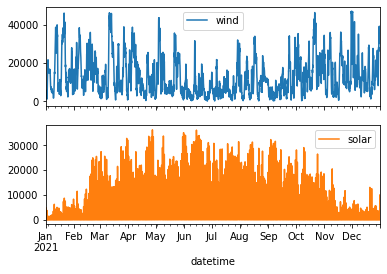

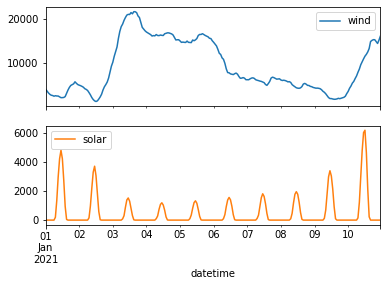

In [22]:
# plot whole year
plot_features = df.copy()
plot_features.index = date_time
plot_features.plot(subplots=True)

# plot first 10 days
plot_features = df[:240].copy()
plot_features.index = date_time[:240]
plot_features.plot(subplots=True)

In [23]:
# Statistics of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wind,8760.0,12973.506250,9861.446223,147.75,5448.875,10200.75,18372.875,46953.25
solar,8760.0,5320.323687,8182.894750,0.00,0.000,160.75,8693.750,36175.25


### Determining the most important frequencies

Text(0.5, 0, 'Frequency (log scale)')

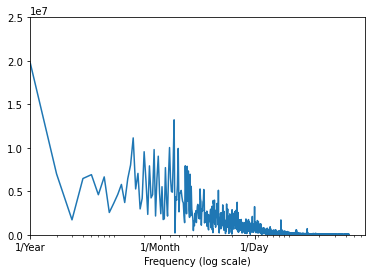

In [24]:
fft = tf.signal.rfft(df["wind"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["wind"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.plot(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2.5e7)
plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 30.44, 365.2524], labels=['1/Year', '1/Month', '1/Day'])
plt.xlabel('Frequency (log scale)')

Text(0.5, 0, 'Frequency (log scale)')

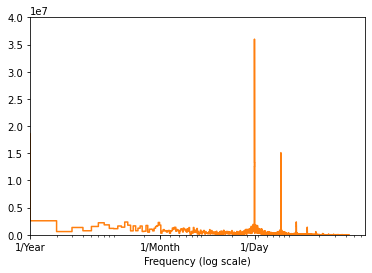

In [25]:
from turtle import color

fft = np.fft.rfft(df["solar"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["solar"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft), 'tab:orange')
plt.xscale('log')
plt.ylim(0, 4e7)
plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 30.44, 365.2524], labels=['1/Year', '1/Month', '1/Day'])
plt.xlabel('Frequency (log scale)')

### Create periodical time signals

In [26]:
day_s = 24*60*60
year_s = (365.2425)*day_s
timestamp_s = date_time.map(pd.Timestamp.timestamp)

df["day_sin"] = np.sin(timestamp_s * (2 * np.pi / day_s))
df["day_cos"] = np.cos(timestamp_s * (2 * np.pi / day_s))
df["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year_s))
df["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year_s))
df.head()

,wind,solar,day_sin,day_cos,year_sin,year_cos
0,4006.75,0.0,-6.012051e-12,1.000000,0.010881,0.999941
1,3573.75,0.0,2.588190e-01,0.965926,0.011597,0.999933
2,3145.25,0.0,5.000000e-01,0.866025,0.012314,0.999924
3,2828.50,0.0,7.071068e-01,0.707107,0.013031,0.999915
4,2608.75,0.0,8.660254e-01,0.500000,0.013747,0.999905


Text(0.5, 1.0, 'Time of day signal')

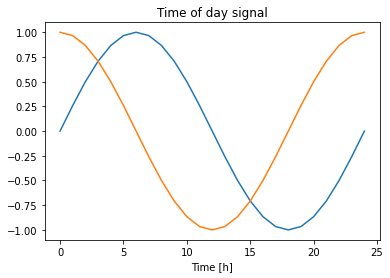

In [27]:
# plotting a day
plt.plot(np.array(df['day_sin'])[:25])
plt.plot(np.array(df['day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### Split the data

In [28]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

In [29]:
train_mean = train_df.mean()
train_std = train_df.std()
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

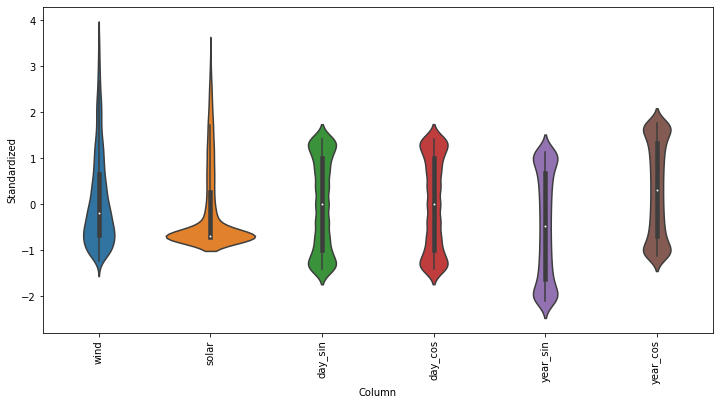

In [30]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Standardized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Standardized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

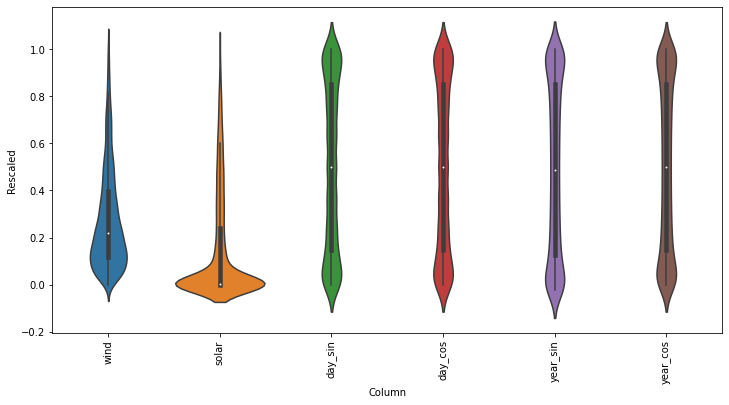

In [31]:
# Alternative: Rescale the data (min-max normalization)
df_scl = (df - train_min) / (train_max - train_min)
df_scl = df_scl.melt(var_name='Column', value_name='Rescaled')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Rescaled', data=df_scl)
_ = ax.set_xticklabels(df.keys(), rotation=90)

What is better?
More info and alternative scalers: https://scikit-learn.org/stable/modules/preprocessing.html

### Data Windowing
#### 1. Indexes and offsets

In [52]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [53]:
w1 = WindowGenerator(input_width=24, label_width=24, shift=24,
                     label_columns=["solar"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['solar']

##### 2. Split

In [54]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [73]:
# Split windows example
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 6)
Inputs shape: (3, 24, 6)
Labels shape: (3, 24, 1)


##### 3. Plot

In [71]:
def plot(self, model=None, plot_col="solar", max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

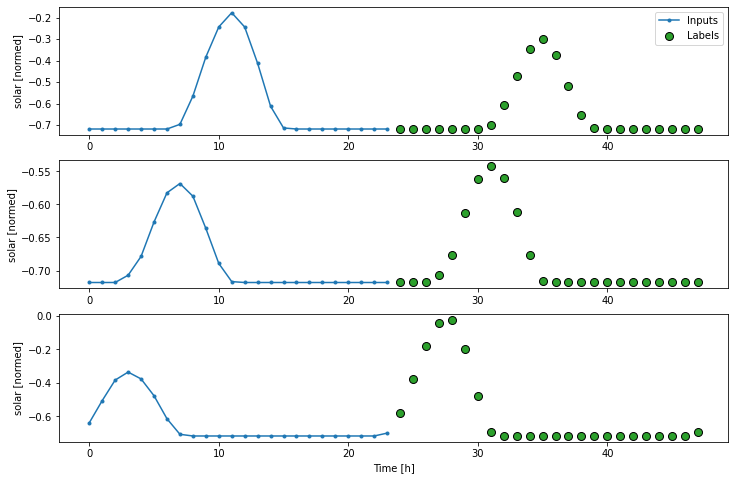

In [70]:
w1.example = example_inputs, example_labels
w1.plot(plot_col="solar")

#### 4. Create `tf.data.Datasets`

In [74]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [75]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [76]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 24, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))